# <font color='darkblue'> Recommendations with IBM Watson. Part II</font>

## <font color='darkblue'> Rank and Content Based Recommendations</font>


In this notebook, rank based recommendations to address the cold start problem and content based recommendations methods are investigated. The dataset is real data from the IBM Watson Studio platform. 

## <font color='darkblue'>Environment SetUp</font>

In [11]:
# General libraries and packages

import pandas as pd
import numpy as np
import re

from ast import literal_eval

# Packages and libraries for content based recs
import re

# NLP packages
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

# Data processing packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Import linear kernel to compute the dot product
from sklearn.metrics.pairwise import linear_kernel

In [2]:
# Import visualization packages and libraries

import matplotlib.pyplot as plt
%matplotlib inline

# Choose style and color palette
import seaborn as sns
sns.set_style("darkgrid")

colors = sns.color_palette('PuBuGn')

In [3]:
# Use 2 decimal places in output display
pd.set_option("display.precision", 2)

# Don't wrap dataframe across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set the maximum widths of columns
pd.set_option("display.max_colwidth", 90)

# Set max rows displayed in output to 20
pd.set_option("display.max_rows", 20)

## <font color='darkblue'>Upload Preprocessed Data</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
        <li>There are 2 files to upload.</li>
        <li>One is centered on the user information, the other on the article information.</li>
    </ul>

</div>

In [4]:
# Read in the user-item interaction files
articles_per_user = pd.read_csv('data/articles_per_user.csv', 
                                index_col=[0], 
                                converters={'viewed_articles': literal_eval}) # to keep int type

# Read the articles information files
users_per_article = pd.read_csv('data/users_per_article.csv', 
                                index_col=[0],
                               converters={'users_accessed': literal_eval}) # to keep int type

In [5]:
# Check the user_item dataframes
articles_per_user.head(2)

,user_id,viewed_articles,articles_count,unique_articles_count
0,1,"[1430.0, 1430.0, 732.0, 1429.0, 43.0, 109.0, 1232.0, 310.0, 1293.0, 1406.0, 1406.0, 32...",47,36
1,2,"[1314.0, 1305.0, 1024.0, 1176.0, 1422.0, 1427.0]",6,6


In [6]:
# Check the articles information dataframe
users_per_article.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0,Communicating data science: A guide to presenting your work,[]


## <a class="anchor" id="Rank">Rank-Based Recommendations</a>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
<li>The dataset does not contain ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can be based on how often an article was interacted with.</li>
    </ul>

</div>

### <font color='darkblue'>Get the top n most popular articles</font>

In [7]:
# Function to retrieve the ids and title of the most viewed n articles
def get_top_articles(n):
    
    '''
    Finds the n most popular articles.
    
    INPUT:
        n (int) - specifies how many items should be returned
    OUTPUT:
        article_ids (list) - the ids of the n most popular articles
        titles (list) - the titles of the n most popular articles
    '''
    
    df_top_n = users_per_article.nlargest(n, 'views')
    titles = list(df_top_n.doc_name)
    article_ids = list(df_top_n.article_id)
    return article_ids, titles

In [8]:
# The ids of the 5 most popular articles
get_top_articles(5)[0]

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

In [9]:
# The titles of the 5 most popular articles
get_top_articles(5)[1]

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

## <a class="anchor" id="Content-Recs">Content Based Recommendations</a>

## <font color='darkblue'>Baseline Model</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>
<li>In this section we work with users_per_article dataframe that contains content information.</li>
<li>The text is preprocessed using a tokenizer function, then vectorized with TfidfVectorizer from sklearn.</li>
<li>The cosine similarity scores are computed with linear_kernel in sklearn.</li>
</ul>

</div>

In [9]:
# Make a copy of the dataframe
content = users_per_article.copy()

In [10]:
# Dataframe that retains article_id and doc_name 
df_titles = content[['article_id', 'doc_name']]

# check the output
df_titles.head(2)

,article_id,doc_name
0,0.0,detect malfunctioning iot sensors with streaming analytics
1,1.0,Communicating data science: A guide to presenting your work


### <font color='darkblue'>Preprocess text and create TF-IDF matrix</font>

In [90]:
def tokenize(text):
    
    """
    Contains the pre-processing steps for a document:
        - tokenize
        - lemmatize
        - lowercasing
        - removes stopwords in English language
        
    INPUT (string) - raw message
    OUTPUT (list)  - clean tokens
    """
    
    # remove punctuation and unusual characters 
    text = re.sub(r"[^a-zA-Z0-9]", " ", text).strip()
    
    # split into words
    words = word_tokenize(text)
    
    # lemmatize - reduce words to their root form
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    # case normalize and remove leading & trailing empty spaces
    words = [w.lower().strip() for w in words]
    
    # remove stopwords, keep not and can
    clean_words = [w for w in words if w not in stopwords.words('english')]
                  # or w in ['not', 'can', 'r']]
    
    return clean_words

In [13]:
# Create an instance of the TF-IDF vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# Construct the TF-IDF matrix 
tfidf_matrix = tfidf.fit_transform(df_titles['doc_name'])

In [14]:
# Output the shape of the TF-IDF matrix
tfidf_matrix.shape

(1328, 1946)

### <font color='darkblue'>Compute the cosine similarity scores</font>

In [15]:
# Compute the cosine similarity matrix 
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
# Check the output
cosine_sim.shape

(1328, 1328)

### <font color='darkblue'>Build the recommender function</font>

In [22]:
def get_article_info(article_id, df_titles):
    '''
    INPUT:
    article_id (int) - unique article identifier
    df_titles (pd.DataFrame) - contains article_id, title
    
    OUTPUT:
    article_title (str) - the article name associated with the provided article id
    '''
    
    article_title = df_titles[df_titles['article_id']==article_id]['doc_name'].unique()[0]
    return article_id, article_title

In [17]:
# Print a sample output
print(f'The title of the article with id = 542 is: {get_article_info(542, df_titles)[1]}.')

The title of the article with id = 542 is: getting started with python.


In [16]:
# Function that takes in the article id as input and gives n recommendations
def content_recommender_tfidf(article_id, n, cosine_sim, df_titles):
    '''
    INPUT:
    article_id (int) - unique article identifier
    n (int) - how many recommendations should be returned
    cosine_sim (np.ndarray) - matrix of cosine similarities
    df (pd.DdataFrame) - contains title and article id
    
    OUTPUT:
    recommended_articles (list) - recommended articles (ids and titles), 
                                  sorted by cosine similarity
    '''
    # Get the information for the given article id
    given_article = get_article_info(article_id, df_titles)
    
    # Obtain the matrix index that matches the article id
    matrix_index = df_titles[df_titles['article_id']==article_id].index.values[0]
    
    # Sort the scores based on the cosine similarity scores with given article index, ignore the first entry
    sim_scores = pd.Series(cosine_sim[matrix_index]).sort_values(ascending=False).iloc[1:]
    
    # Get the indices corresponding to the scores of the n most similar articles
    sim_scores_n = list(sim_scores[:n].index.values)
    
    # Return the top n most similar article_ids as a pandas dataframe
    recommended_articles = df_titles.iloc[sim_scores_n]
    
    return given_article, recommended_articles

### <font color='darkblue'>Make content recommendations with the baseline model</font>

In [17]:
def make_content_recs_tfidf(user_id, 
                      cosine_sim, 
                      m, 
                      df=articles_per_user, 
                      df_content=users_per_article):
    '''
    INPUT:
        user_id (int) - unique numeric user identifier
        m (int) - the number of recommendations we want for the user
        df (pd.DataFrame) - contains users and articles interactions
        df_content (pd.DataFrame) - contains titles and article_ids
    
    OUTPUT:
        recs_ids (list) - list of recommendations for the user by article id
        rec_names (list) - list of recommendations for the user by article title
    
    Description:
        Loops through the articles based on closeness to the articles seen by the user.
        For each article seen by the user - finds n most similar articles based on 
        content recommendations. Does this until m recommendations are found.
    
    Notes:
        The articles that have the most total article interactions are chosen first.
   
    '''
    # List of recommended articles by id, and by title
    recommendations = []
    
    # Ids of articles seen by user  
    articles_ids_seen = articles_per_user.loc[user_id].viewed_articles
    
    for art_id in articles_ids_seen:
        
        # choose n such that we get similar articles to all articles viewed
        if len(articles_ids_seen) >= 5:
            n = 2
        elif len(articles_ids_seen) == 4:
            n = 3
        else:
            n = 10
        
         # get the n most similar articles ids and titles
        similar_articles_ids = content_recommender_tfidf(
            art_id, n, cosine_sim, df_titles)[1]['article_id'].tolist()
        similar_articles = content_recommender_tfidf(
            art_id, n, cosine_sim, df_titles)[1]['doc_name'].tolist()

        # remove the ids of the articles in articles_ids_seen and available
        articles_ids_to_recommend = np.setdiff1d(
            similar_articles_ids, articles_ids_seen)
        
        # remove the articles already added to the recs list
        articles_ids_to_add = np.setdiff1d(
            articles_ids_to_recommend, recommendations)
        
        # add the sorted article ids
        recommendations.extend(articles_ids_to_add)
        
        # break when we have enough articles to recommend
        if len(recommendations) >= m:
            break
    
    # retain the first m recommendations
    recs = recommendations[:m]
    
    # get the articles titles
    complete_recs = [get_article_info(article_id, df_titles) for article_id in recs]
    
    return complete_recs


## <font color='darkblue'>Sentence Transformers</font>

In [18]:
# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer, util
import torch

# Create the model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Create embeddings for the collection of titles
corpus_embeddings = model.encode(users_per_article.doc_name.values, 
                                 convert_to_tensor=True)

In [19]:
# Function that takes in the article id as input and gives n recommendations
def content_recommender_transformer(article_id, k, df_titles):
    '''
    INPUT:
    article_id (int) - unique article identifier
    n (int) - how many recommendations should be returned
    cosine_sim (np.ndarray) - matrix of cosine similarities
    df (pd.DdataFrame) - contains title and article id
    
    OUTPUT:
    recommended_articles (list) - recommended articles (ids and titles), 
                                  sorted by cosine similarity
    '''
    # Get the information for the given article id
    select_title = get_article_info(article_id, df_titles)[1]
    
    # Create an embedding for select article title
    select_article_embedding = model.encode(select_title, convert_to_tensor=True)
    
    # Compute cosine similarity scores between the select article and the corpus
    cos_scores = util.pytorch_cos_sim(select_article_embedding, corpus_embeddings)[0]
    
    # Select the highest k scores
    top_results = torch.topk(cos_scores, k)
    
    # Get a list of recommended article ids
    top_ids = top_results[1].tolist()[1:]
    
    # Return the top n most similar article_ids as a pandas dataframe
    recommended_articles = df_titles.iloc[top_ids]
    
    return select_title, recommended_articles

### <font color='darkblue'>Make content recommendations with transformers</font>

In [20]:
def make_content_recs_transformers(user_id, m, 
                      df=articles_per_user, 
                      df_content=users_per_article):
    '''
    INPUT:
        user_id (int) - unique numeric user identifier
        m (int) - the number of recommendations we want for the user
        df (pd.DataFrame) - contains users and articles interactions
        df_content (pd.DataFrame) - contains titles and article_ids
    
    OUTPUT:
        recs_ids (list) - list of recommendations for the user by article id
        rec_names (list) - list of recommendations for the user by article title
    
    Description:
        Loops through the articles based on closeness to the articles seen by the user.
        For each article seen by the user - finds n most similar articles based on 
        content recommendations. Does this until m recommendations are found.
    
    Notes:
        The articles that have the most total article interactions are chosen first.
   
    '''
    # List of recommended articles by id, and by title
    recommendations = []
    
    # Ids of articles seen by user  
    articles_ids_seen = articles_per_user.loc[user_id].viewed_articles
    
    for art_id in articles_ids_seen:
        
        # choose n such that we get similar articles to all articles viewed
        if len(articles_ids_seen) >= 5:
            n = 2
        elif len(articles_ids_seen) == 4:
            n = 3
        else:
            n = 12
        
        # get the n most similar articles ids and titles
        similar_articles_ids = content_recommender_transformer(
            art_id, n, df_titles)[1]['article_id'].tolist()
        similar_articles = content_recommender_transformer(
            art_id, n, df_titles)[1]['doc_name'].tolist()

        # remove the ids of the articles in articles_ids_seen and available
        articles_ids_to_recommend = np.setdiff1d(
            similar_articles_ids, articles_ids_seen)
        
        # remove the articles already added to the recs list
        articles_ids_to_add = np.setdiff1d(
            articles_ids_to_recommend, recommendations)
        
        # add the sorted article ids
        recommendations.extend(articles_ids_to_add)
        
        # break when we have enough articles to recommend
        if len(recommendations) >= m:
            break
    
    # retain the first m recommendations
    recs = recommendations[:m]
    
    # get the articles titles
    complete_recs = [get_article_info(article_id, df_titles) for article_id in recs]
    
    return complete_recs


### <font color='darkblue'>Examples: finding similar articles</font>

In [23]:
# Choose the id for the test article
article_id = 20

# Create the list of recommendations using the baseline model
recommendations_tfidf_list_20 = content_recommender_tfidf(article_id, 10, cosine_sim, df_titles)

# Print the information for the test article
print(f'The article with id = {article_id} for which we give recommendations is:\n{recommendations_tfidf_list_20[0][1]}')

# Print the recommended articles information
print(f'\nThe baseline model recommended articles are:')
recommendations_tfidf_list_20[1]

The article with id = 20 for which we give recommendations is:
working interactively with rstudio and notebooks in dsx

The baseline model recommended articles are:


,article_id,doc_name
373,373.0,working with notebooks in dsx
763,763.0,load data into rstudio for analysis in dsx
182,182.0,Overview of RStudio IDE in DSX
355,355.0,run shiny applications in rstudio in dsx
626,626.0,analyze db2 warehouse on cloud data in rstudio in dsx
665,665.0,get social with your notebooks in dsx
958,958.0,using dsx notebooks to analyze github data
474,474.0,publish notebooks to github in dsx
930,930.0,how to use version control (github) in rstudio within dsx?
821,821.0,using rstudio in ibm data science experience


In [24]:
# Print the recommended articles using transformers
print(f'\nThe transformer model recommended articles are:')
recommendations_transf_list_20 = content_recommender_transformer(20, 11, df_titles)
recommendations_transf_list_20[1]


The transformer model recommended articles are:


,article_id,doc_name
373,373.0,working with notebooks in dsx
182,182.0,Overview of RStudio IDE in DSX
763,763.0,load data into rstudio for analysis in dsx
665,665.0,get social with your notebooks in dsx
821,821.0,using rstudio in ibm data science experience
474,474.0,publish notebooks to github in dsx
806,806.0,Collaborate on projects in DSX
355,355.0,run shiny applications in rstudio in dsx
395,395.0,run dsx notebooks on amazon emr
277,277.0,work with data connections in dsx


In [25]:
list_transf_20 = recommendations_transf_list_20[1].article_id.values
list_tfidf_20 = recommendations_tfidf_list_20[1].article_id.values

# The articles recommended one model but not the other
print(f'For article_id = 20')
print(f'Articles recommended by transformer but not by baseline model:{set(list_transf_20) - set(list_tfidf_20)}')
print(f'Articles recommended by baseline but not by transformer model:{set(list_tfidf_20) - set(list_transf_20)}')

For article_id = 20
Articles recommended by transformer but not by baseline model:{395.0, 277.0, 806.0}
Articles recommended by baseline but not by transformer model:{930.0, 958.0, 626.0}


In [26]:
# Choose the id for the test article
article_id = 500

# Create the list of recommendations using baseline model
recommendations_tfidf_list_500 = content_recommender_tfidf(article_id, 10, cosine_sim, df_titles)

# Print the information for the test article
print(f'The article with id = {article_id} for which we give recommendations is:\n{recommendations_tfidf_list_500[0][1]}')

# Print the recommended articles information
print(f'\nThe baseline model recommended articles are:')
recommendations_tfidf_list_500[1]

The article with id = 500 for which we give recommendations is:
the difference between ai, machine learning, and deep learning?

The baseline model recommended articles are:


,article_id,doc_name
313,313.0,what is machine learning?
260,260.0,the machine learning database
762,762.0,From Machine Learning to Learning Machine (Dinesh Nirmal)
237,237.0,deep learning with data science experience
1035,1035.0,machine learning for the enterprise.
800,800.0,machine learning for the enterprise
336,336.0,challenges in deep learning
337,337.0,generalization in deep learning
1004,1004.0,how to get a job in deep learning
809,809.0,use the machine learning library


In [27]:
# Print the recommended articles information
print(f'\nThe transformer model recommended articles are:')
recommendations_transf_list_500 = content_recommender_transformer(500, 11, df_titles)
recommendations_transf_list_500[1]


The transformer model recommended articles are:


,article_id,doc_name
336,336.0,challenges in deep learning
278,278.0,deep learning trends and an example
337,337.0,generalization in deep learning
313,313.0,what is machine learning?
762,762.0,From Machine Learning to Learning Machine (Dinesh Nirmal)
1313,1429.0,use deep learning for image classification
237,237.0,deep learning with data science experience
833,833.0,machine learning and the science of choosing
195,195.0,"artificial intelligence, ethically speaking – inside machine learning – medium"
532,532.0,the two phases of gradient descent in deep learning


In [28]:
list_transf_500 = recommendations_transf_list_500[1].article_id.values
list_tfidf_500 = recommendations_tfidf_list_500[1].article_id.values

# The articles recommended one model but not the other
print(f'For article_id = 500')
print(f'Articles recommended by transformer but not by baseline model:{set(list_transf_500) - set(list_tfidf_500)}')
print(f'Articles recommended by baseline but not by transformer model:{set(list_tfidf_500) - set(list_transf_500)}')

For article_id = 500
Articles recommended by transformer but not by baseline model:{833.0, 195.0, 532.0, 1429.0, 278.0}
Articles recommended by baseline but not by transformer model:{800.0, 260.0, 809.0, 1035.0, 1004.0}


### <font color='darkblue'>Examples: Make content recommendations</font>

In [29]:
# Take a look at the unique articles seen by user_id=40
articles_ids_seen_40 = articles_per_user.loc[40].viewed_articles
articles_seen_40 = [get_article_info(article_id, 
                                     df_titles) for article_id in articles_ids_seen_40]
print(f'The articles accessed by user_id=40 are:')
set(articles_seen_40)

The articles accessed by user_id=40 are:


{(151.0, 'jupyter notebook tutorial'),
 (162.0, 'an introduction to stock market data analysis with r (part 1)'),
 (486.0, 'use spark r to load and analyze data'),
 (542.0, 'getting started with python'),
 (645.0, 'how to perform a logistic regression in r'),
 (692.0, '15 page tutorial for r'),
 (1198.0, 'country statistics: commercial bank prime lending rate'),
 (1304.0, 'gosales transactions for logistic regression model'),
 (1368.0, 'putting a human face on machine learning'),
 (1430.0,
  'using pixiedust for fast, flexible, and easier data analysis and experimentation'),
 (1436.0, 'welcome to pixiedust')}

In [30]:
# Take a look at the list of recommended articles using the baseline model
print(f'The articles recommended by baseline model to user_id=40 are:')
recs_tfidf_40 = make_content_recs_tfidf(40, cosine_sim, 10, 
                                        articles_per_user, users_per_article)
recs_tfidf_40

The articles recommended by baseline model to user_id=40 are:


[(82.0, 'build a logistic regression model with wml & dsx'),
 (1305.0, 'gosales transactions for naive bayes model'),
 (110.0, 'pixiedust: magic for your python notebook'),
 (729.0, 'pixiedust 1.0 is here! – ibm watson data lab'),
 (329.0, 'introduction to market basket analysis in\xa0python'),
 (886.0, 'Perform market basket analysis using dashDB and R'),
 (108.0,
  '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object'),
 (198.0, 'New Simple Data Pipe: Easier cloud data movement'),
 (528.0, '10 tips on using jupyter notebook'),
 (906.0, 'jupyter (ipython) notebooks features')]

In [31]:
# Separate tuples of ids and titles for the recommended articles
recs_tfidf_40_ids, recs_tfidf_40_titles = zip(*recs_tfidf_40)

In [32]:
# Take a look at the list of recommended articles using the transformer model
print(f'The articles recommended by the transformer model to user_id=40 are:')
recs_transf_40 = make_content_recs_transformers(40, 11, 
                                        articles_per_user, users_per_article)
recs_transf_40

The articles recommended by the transformer model to user_id=40 are:


[(617.0, 'pixiedust gets its first community-driven feature in 1.0.4'),
 (886.0, 'Perform market basket analysis using dashDB and R'),
 (1161.0, 'analyze data, build a dashboard with spark and pixiedust'),
 (528.0, '10 tips on using jupyter notebook'),
 (351.0, 'do i need to learn r?'),
 (1425.0, 'use spark for r to load data and run sql queries'),
 (426.0, 'migrating to python 3 with pleasure'),
 (511.0, 'Put a human face on machine learning with WML & DSX'),
 (1196.0, 'country statistics: central bank discount rate')]

In [33]:
# Separate tuples of ids and titles for the recommended articles
recs_transf_40_ids, recs_transf_40_titles = zip(*recs_transf_40)

In [34]:
# Take a look at the unique articles seen by user_id=178
articles_ids_seen_178 = articles_per_user.loc[178].viewed_articles
articles_seen_178 = [get_article_info(article_id, df_titles) for article_id in articles_ids_seen_178]
print(f'The articles accessed by user_id=178 are:')
set(articles_seen_178)

The articles accessed by user_id=178 are:


{(173.0, '10 must attend data science, ml and ai conferences in 2018')}

In [36]:
# Take a look at the list of recommended articles
print(f'The articles recommended by the baseline model to user_id=178 are:')
recs_tfidf_178 = make_content_recs_tfidf(178, cosine_sim, 10, 
                                         articles_per_user, users_per_article)
recs_tfidf_178

The articles recommended by the baseline model to user_id=178 are:


[(508.0, 'data science in the cloud'),
 (528.0, '10 tips on using jupyter notebook'),
 (661.0, '21 Must-Know Data Science Interview Questions and Answers'),
 (679.0, 'this week in data science'),
 (715.0,
  "for ai to get creative, it must learn the rules--then how to break 'em"),
 (784.0,
  '10 data science, machine learning and ai podcasts you must listen to'),
 (878.0, '10 data science podcasts you need to be listening to right now'),
 (967.0, 'ml algorithm != learning machine'),
 (986.0, 'r for data science'),
 (990.0, 'this week in data science (january 10, 2017)')]

In [37]:
# Take a look at the list of recommended articles using the transformer model
print(f'The articles recommended by the transformer model to user_id=40 are:')
recs_transf_178 = make_content_recs_transformers(178, 10, 
                                        articles_per_user, users_per_article)
recs_transf_178

The articles recommended by the transformer model to user_id=40 are:


[(8.0, 'data science bowl 2017'),
 (78.0, 'this week in data science (may 16, 2017)'),
 (101.0, 'how to choose a project to practice data science'),
 (364.0, 'this week in data science (october 18, 2016)'),
 (440.0, 'this week in data science (january 24, 2017)'),
 (493.0, 'This Week in Data Science (October 11, 2016)'),
 (510.0, 'this week in data science (may 30, 2017)'),
 (631.0, 'this week in data science (january 17, 2017)'),
 (661.0, '21 Must-Know Data Science Interview Questions and Answers'),
 (679.0, 'this week in data science')]

In [39]:
# Separate tuples of ids and titles for the recommended articles
recs_transf_178_ids, recs_transf_178_titles = zip(*recs_tfidf_178)

In [38]:
# Separate tuples of ids and titles for the recommended articles
recs_tfidf_178_ids, recs_tfidf_178_titles = zip(*recs_tfidf_178)

## <font color='darkblue'>Topic modeling with BERT</font>

<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>The approach here is after Maarten Grootendorst, Topic Modeling with BERT (Medium, Oct 5, 2020).
    </ul>
</div>

In [42]:
# Create a copy of article information data
metadata = users_per_article.copy()

# Take a look at the data
metadata.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]"
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0,Communicating data science: A guide to presenting your work,[]


In [43]:
# Replace NaN with the string 'none'
metadata.fillna('none', inplace=True)

# Create a new column that combines doc_name and doc_description 
metadata['doc_text'] = metadata['doc_description'] +  ' , ' + metadata['doc_name']

# Check the output
metadata.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed,doc_text
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]","Detect bad readings in real time using Python and Streaming Analytics. , detect malfun..."
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0,Communicating data science: A guide to presenting your work,[],"See the forest, see the trees. Here lies the challenge in both performing and presenti..."


In [44]:
# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer

# Transform the documents into 768-dim real vectors
model = SentenceTransformer('all-mpnet-base-v2')
metadata['vectors'] = metadata['doc_text'].apply(lambda x: model.encode(x))

# Check the output
metadata.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed,doc_text,vectors
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]","Detect bad readings in real time using Python and Streaming Analytics. , detect malfun...","[-0.056983944, -0.0109135825, -0.0042920434, -0.010326301, 0.016904691, 0.0044431784, ..."
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0,Communicating data science: A guide to presenting your work,[],"See the forest, see the trees. Here lies the challenge in both performing and presenti...","[-0.044508077, 0.06600767, -0.035064492, -0.0024267777, 0.001408063, 0.0027797609, 0.0..."


### <font color='darkblue'>Clustering with HDBSAN</font>

In [45]:
import umap

# Reduce the dimensionality of the vectors to 5 while keeping the size of the local neighborhood to 15
embeddings = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       metric='cosine').fit_transform(list(metadata.vectors))

In [46]:
# Add the embeddings to the dataframe
metadata['umap_embed'] = embeddings.tolist()

# Check the output
metadata.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed,doc_text,vectors,umap_embed
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]","Detect bad readings in real time using Python and Streaming Analytics. , detect malfun...","[-0.056983944, -0.0109135825, -0.0042920434, -0.010326301, 0.016904691, 0.0044431784, ...","[1.239950180053711, -0.8587175011634827, 4.635855674743652, 4.153340816497803, 3.36218..."
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0,Communicating data science: A guide to presenting your work,[],"See the forest, see the trees. Here lies the challenge in both performing and presenti...","[-0.044508077, 0.06600767, -0.035064492, -0.0024267777, 0.001408063, 0.0027797609, 0.0...","[0.7916058301925659, 0.8479644060134888, 4.492250442504883, 2.728168249130249, 2.64139..."


In [47]:
# Cluster the documents with HDBSCAN
import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(embeddings)

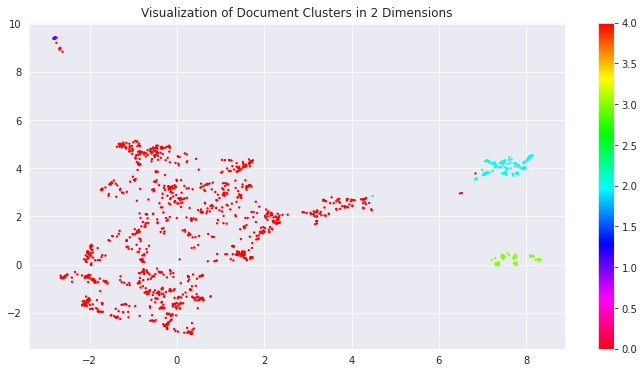

In [51]:
# Visualize the resulting clusters

# Prepare data by creating a 2-dim embedding for each 768-dim vector
umap_data = umap.UMAP(
    n_neighbors=15, n_components=2, 
    min_dist=0.0, metric='cosine').fit_transform(list(metadata.vectors))

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize the clusters clusters
fig, ax = plt.subplots(figsize=(12, 6))
# Define the outliers and the clusters
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

#Create the plot
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=1.0),
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=1.8, cmap='hsv_r')
plt.colorbar();
plt.title('Visualization of Document Clusters in 2 Dimensions');

In [52]:
# Add the topic labels to the dataframe
metadata['labels'] = cluster.labels_.tolist()

# Check the output
metadata.head(2)

,doc_body,doc_description,article_id,views,doc_name,users_accessed,doc_text,vectors,umap_embed,labels
0,"Skip navigation Sign in SearchLoading...\r\n\r\nClose Yeah, keep it Undo CloseTHIS VID...",Detect bad readings in real time using Python and Streaming Analytics.,0.0,14,detect malfunctioning iot sensors with streaming analytics,"[495, 495, 495, 503, 233, 552, 1347, 1051, 785, 2992, 3216, 3570, 4571, 4836]","Detect bad readings in real time using Python and Streaming Analytics. , detect malfun...","[-0.056983944, -0.0109135825, -0.0042920434, -0.010326301, 0.016904691, 0.0044431784, ...","[1.239950180053711, -0.8587175011634827, 4.635855674743652, 4.153340816497803, 3.36218...",4
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data s...,"See the forest, see the trees. Here lies the challenge in both performing and presenti...",1.0,0,Communicating data science: A guide to presenting your work,[],"See the forest, see the trees. Here lies the challenge in both performing and presenti...","[-0.044508077, 0.06600767, -0.035064492, -0.0024267777, 0.001408063, 0.0027797609, 0.0...","[0.7916058301925659, 0.8479644060134888, 4.492250442504883, 2.728168249130249, 2.64139...",4


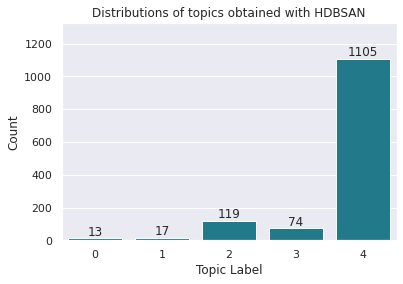

In [53]:
# Visualize the distribution articles by topics

# adjust figure size and font size
sns.set(rc = {'figure.figsize':(6,4)})
sns.set(font_scale=1)

# pad margins so that markers don't get clipped by the axes
plt.margins(x=0.2, y=0.2, tight=True);

# plot the page distribution
ax = sns.countplot(x='labels', data=metadata, color=colors[4])
ax.bar_label(ax.containers[0]);

# Add labels and title
plt.title('Distributions of topics obtained with HDBSAN')
plt.xlabel('Topic Label')
plt.ylabel('Count')
plt.show()

### <font color='darkblue'>Topic extraction</font>

In [54]:
# Create a single combined document for each cluster of documents
docs_df = metadata[['doc_text', 'labels']].copy()
#docs_df['doc_id'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['labels'], as_index=False).agg({'doc_text': ' '.join})
docs_per_topic

,labels,doc_text
0,0,"Here’s this week’s news in Data Science and Big Data. , This Week in Data Science (Se..."
1,1,"Here’s this week’s news in Data Science and Big Data. , this week in data science (apr..."
2,2,"none , adolescent fertility rate (births per 1,000 women ages 15-19), worldwide none ,..."
3,3,"Data products have always been an instrumental part of Airbnb’s service. However, we h..."
4,4,"Detect bad readings in real time using Python and Streaming Analytics. , detect malfun..."


<div class="alert alert-block alert-info">

<b>NOTES</b>:
    <ul>We use the class based TF-IDF vectorizer to output a np.array, instead of a sparse matrix,
        the TfidfVectorizer would output.
    </ul>
</div>

In [91]:
# Apply the class-based TF-IDF vectorizer

def ctfidf(documents, m, ngram_range=(1, 1)):
    '''
    Compute tfidf vector for each class document.
    INPUT:
        documents (list) - corpus of documents
        m (int) - number of documents, i.e. number of topics
        ngram_range (tuple) - specify n-grams values
    OUTPUT: 
        tf_idf (np.array) - contains tf_idf scores of each word
        count (CountVectorizer) - instance of sklearn count vectorizer
    '''
    
    # Create a list of tokens, remove stopwords
    #count = CountVectorizer(
        #ngram_range=ngram_range,
        #stop_words="english").fit(documents)
    
    count = CountVectorizer(
        tokenizer=tokenize,
        ngram_range=ngram_range).fit(documents)
    
    # Count frequency of each word for each class
    t = count.transform(documents).toarray()
    
    # The total number of words in the corpus
    w = t.sum(axis=1)
    
    # Divide count frequency by total word count 
    tf = np.divide(t.T, w) # term frequency
    
    # The total number of words in the document
    sum_t = t.sum(axis=0)
    
    # Compute inverse-document-frequency
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    
    # Compute tf-idf score for each word
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [92]:
# Apply the class tfidf to the text corpus
tf_idf, count = ctfidf(docs_per_topic.doc_text.values, m=len(docs_df))

In [60]:
type(count)

sklearn.feature_extraction.text.CountVectorizer

In [61]:
# Create an instance of the TF-IDF vectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize)

# Construct the TF-IDF matrix 
tfidf_matrix = tfidf.fit_transform(docs_per_topic['doc_text'])

In [69]:
tfidf_matrix

<5x4211 sparse matrix of type '<class 'numpy.float64'>'
	with 4466 stored elements in Compressed Sparse Row format>

In [62]:
words=tfidf.get_feature_names()

In [66]:
labels=list(docs_per_topic.labels)

In [70]:
def extract_top_n_words_per_topic(tfidf_matrix, tfidf, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.labels)
    tf_idf_transposed = tfidf_matrix.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i,
                   label in enumerate(labels)}
    return top_n_words

In [71]:
top_n_words = extract_top_n_words_per_topic(tfidf_matrix, tfidf, docs_per_topic, n=20)

AttributeError: argsort not found

In [93]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.labels)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i,
                   label in enumerate(labels)}
    return top_n_words

In [81]:
tf_idf.size

21055

In [97]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['stopWord1','stopWord2']
stopwords.extend(newStopWords)

stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('newWord')

NameError: name 'nltk' is not defined

In [73]:
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['labels'])
                     .doc_text
                     .count()
                     .reset_index()
                     .rename({"topic": "topic", "doc_text": "size"}, axis='columns')
                     .sort_values("size", ascending=False))
    return topic_sizes

In [94]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
#topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head()

In [95]:
top_n_words[4][:14]

[('ibm', 0.01940209675929379),
 ('using', 0.017402415003821368),
 ('cloudant', 0.017196753962416364),
 ('database', 0.016664828093587956),
 ('compose', 0.016565437778961464),
 ('learning', 0.016515367751941432),
 ('use', 0.015740854919239135),
 ('spark', 0.014638668952132701),
 ('machine', 0.01405151488705205),
 ('watson', 0.01334761317088438),
 ('science', 0.013289244358899532),
 ('python', 0.011783681445485418),
 ('cloud', 0.011722915082391303),
 ('r', 0.011620082493949274)]

In [115]:
top_n_words[4][:10]

[('ibm', 0.020916804182277444),
 ('using', 0.018761008743000813),
 ('cloudant', 0.018539291895365198),
 ('compose', 0.017858689321826157),
 ('learning', 0.017804710364625168),
 ('use', 0.01696973188475882),
 ('spark', 0.015781499069902036),
 ('machine', 0.014995175433849655),
 ('database', 0.014499971111405233),
 ('watson', 0.014389651513434574)]

In [96]:
top_n_words[2][:10]

[('country', 0.26655789674114894),
 ('none', 0.2479787516695963),
 ('statistic', 0.15556625323895193),
 ('population', 0.08051437703276165),
 ('rate', 0.07313047390234732),
 ('worldwide', 0.07058751623777522),
 ('demographic', 0.07058751623777522),
 ('measure', 0.06417046930706838),
 ('united', 0.06193413617904742),
 ('total', 0.06017114159879711)]

In [83]:
top_n_words[2][:10]

[('country', 0.3258899326769857),
 ('statistics', 0.19019311157037166),
 ('population', 0.09243579732075376),
 ('worldwide', 0.08629930381279557),
 ('rate', 0.08329178346697753),
 ('measures', 0.08001381730020186),
 ('demographic', 0.08001381730020186),
 ('states', 0.07571980315179776),
 ('united', 0.07571980315179776),
 ('total', 0.07356439079263738)]

In [84]:
top_n_words[3][:10]

[('airbnb', 0.5102910888887304),
 ('analytics', 0.35279374254181356),
 ('reviews', 0.2534481844069044),
 ('listings', 0.22478676536015968),
 ('calendar', 0.19985093456929912),
 ('antwerp', 0.05595310813413483),
 ('portland', 0.05595310813413483),
 ('venice', 0.04404446054001159),
 ('toronto', 0.04404446054001159),
 ('athens', 0.04404446054001159)]

In [116]:
top_n_words[0][:10]

[('week', 0.4781825394659206),
 ('2017', 0.33134758554363625),
 ('science', 0.28676225259555815),
 ('news', 0.2683012783134132),
 ('big', 0.2502574474108359),
 ('april', 0.11276750338590462),
 ('february', 0.10908423961228939),
 ('january', 0.10597008446426395),
 ('march', 0.0656392136310751),
 ('28', 0.05863772695875241)]

In [86]:
top_n_words[1][:10]

[('week', 0.40951618864295974),
 ('news', 0.2734305674576402),
 ('science', 0.2554069336266321),
 ('big', 0.24003932326049723),
 ('2016', 0.22195600798688817),
 ('august', 0.1641762181647729),
 ('september', 0.1313409745318183),
 ('30', 0.07645037822913452),
 ('26', 0.04230252547080223),
 ('05', 0.04230252547080223)]

In [ ]:


# Calculate Within Clusters SS for a range of k values
# Adapted from: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means

from sklearn.cluster import KMeans

# Function returns WSS score for k values from 1 to kmax

def calculate_WSS(points, kmax):
    
    sse = []
    
    for k in range(4, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
        sse.append(curr_sse)
    return sse

# Create a list of vectors for Kmeans model
X = np.array(metadata['vectors'].tolist())

TOKENIZERS_PARALLELISM=False
wsse = calculate_WSS(X, 10)

wss_results = pd.DataFrame({'k':list(range(4,11)), 'wss' : wsse})

ax1 = wss_results.plot.scatter(x='k',
                      y='wss',
                      c='DarkBlue')

plt.plot(wss_results.k, wss_results.wss)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show(


In [ ]:
# Install packages to generate the BERT embeddings
from sentence_transformers import SentenceTransformer

# Transform the documents into 768-dim real vectors
model = SentenceTransformer('all-mpnet-base-v2')
metadata['vectors'] = metadata['doc_text'].apply(lambda x: model.encode(x))


# Calculate Within Clusters SS for a range of k values
# Adapted from: https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means

from sklearn.cluster import KMeans

# Function returns WSS score for k values from 1 to kmax

def calculate_WSS(points, kmax):
    
    sse = []
    
    for k in range(4, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0
        
        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
        sse.append(curr_sse)
    return sse

# Create a list of vectors for Kmeans model
X = np.array(metadata['vectors'].tolist())

TOKENIZERS_PARALLELISM=False
wsse = calculate_WSS(X, 10)

wss_results = pd.DataFrame({'k':list(range(4,11)), 'wss' : wsse})

ax1 = wss_results.plot.scatter(x='k',
                      y='wss',
                      c='DarkBlue')

plt.plot(wss_results.k, wss_results.wss)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show(


In [ ]:
## Import libraries
from nltk.cluster import KMeansClusterer
import nltk

def clustering_question(metadata,NUM_CLUSTERS):

    sentences = metadata['doc_name']

    X = np.array(metadata['vectors'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    metadata['cluster'] = pd.Series(assigned_clusters, index=metadata.index)
    metadata['centroid'] = metadata['cluster'].apply(lambda x: kclusterer.means()[x])

    return metadata, assigned_clusters

from sklearn.metrics import silhouette_score

sil_avg = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for k in range_n_clusters:
 kmeans = KMeans(n_clusters = k).fit(X)
 labels = kmeans.labels_
 sil_avg.append(silhouette_score(X, labels, metric = 'euclidean'))


plt.plot(range_n_clusters,sil_avg,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis For Optimal k')
plt.show()

#Using the above Silhouette analysis, we can choose K’s optimal value as 3, 6, 8 
#because the average silhouette score is higher and indicates that the 
#data points are optimally positioned.

# Reduce the dimensionality of the embedding to 10 while keeping the size of the local neighborhood to 15

umap_embeddings = umap.UMAP(n_neighbors=15,
                           n_components=5,
                           metric='cosine').fit_transform(embeddings)

standard_embedding = umap.UMAP(random_state=42).fit_transform(list(metadata.vectors))
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

